In [60]:
# import all relevant libraries for creation of model for brain stroke
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, \
                            plot_confusion_matrix, plot_roc_curve, roc_auc_score, classification_report, \
                            ConfusionMatrixDisplay, f1_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

from xgboost import XGBClassifier


ModuleNotFoundError: No module named 'xgboost'

In [2]:
# perform initial inspection of dataset
df = pd.read_csv('brain_stroke.csv')

In [3]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


We can see that there are both categorical and numerical features, so we will need to perform feature engineering to get all the columns in the format that we would like. 

In [4]:
df.shape

(4981, 11)

In [5]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000
mean,43.419859,0.096165,0.055210,105.943562,28.498173,0.049789
std,22.662755,0.294848,0.228412,45.075373,6.790464,0.217531
min,0.080000,0.000000,0.000000,55.120000,14.000000,0.000000
25%,25.000000,0.000000,0.000000,77.230000,23.700000,0.000000
50%,45.000000,0.000000,0.000000,91.850000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,113.860000,32.600000,0.000000
max,82.000000,1.000000,1.000000,271.740000,48.900000,1.000000


In [6]:
df['stroke'].value_counts()

0    4733
1     248
Name: stroke, dtype: int64

We have a relatively large class imbalance, so we will use SMOTE to balance our classes.

In [7]:
df.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

### Modeling Set Up


In [8]:
# Create our sub pipelines for numeric and categorial data

subpipe_num = Pipeline(steps=[('ss', StandardScaler())])
subpipe_cat = Pipeline(steps=[('ohe', OneHotEncoder(sparse=False,
                                                    handle_unknown='ignore'))])

subpipe_smote = SMOTE(sampling_strategy='minority', random_state=42)

CT = ColumnTransformer(transformers=[('subpipe_num', subpipe_num, [1,7,8]), 
                                     ('subpipe_cat', subpipe_cat, [0,2,3,4,5,6,9])])

In [9]:
X = df.drop(columns='stroke')
y = df['stroke']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

In [11]:
X_train_fin, X_val, y_train_fin, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=24) 

In [12]:
CT.fit(X_train_fin)

ColumnTransformer(transformers=[('subpipe_num',
                                 Pipeline(steps=[('ss', StandardScaler())]),
                                 [1, 7, 8]),
                                ('subpipe_cat',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 [0, 2, 3, 4, 5, 6, 9])])

In [13]:
X_train_fin = CT.transform(X_train_fin)
X_val = CT.transform(X_val)
X_test = CT.transform(X_test)

In [14]:
X_train_fin.shape


(3187, 21)

In [15]:
X_val.shape

(797, 21)

In [16]:
X_test.shape

(997, 21)

# Modeling


## Dummy Model

In [17]:
dummy = DummyClassifier(strategy='most_frequent')

In [18]:
dummy.fit(X_train_fin, y_train_fin)

DummyClassifier(strategy='most_frequent')

In [19]:
dummy.score(X_val, y_val)

0.9560853199498118

/Users/zachpollatsek/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


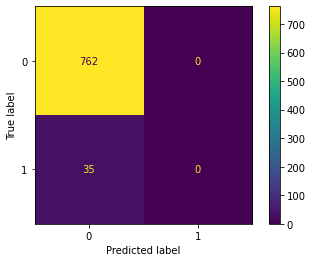

In [20]:
plot_confusion_matrix(dummy, X_val, y_val);

## Logistic Regression

In [21]:
lr = LogisticRegression(random_state=24)

In [22]:
lr.fit(X_train_fin, y_train_fin)

LogisticRegression(random_state=24)

In [23]:
lr.score(X_val, y_val)

0.9560853199498118

/Users/zachpollatsek/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


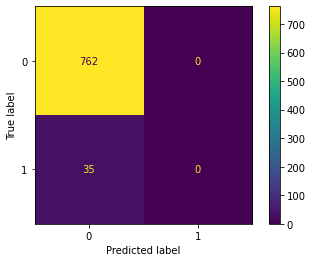

In [24]:
plot_confusion_matrix(lr, X_val, y_val)

## Decision Tree

In [25]:
dtc = DecisionTreeClassifier(random_state=24)

In [26]:
dtc.fit(X_train_fin, y_train_fin)

DecisionTreeClassifier(random_state=24)

In [27]:
dtc.score(X_train_fin, y_train_fin)

1.0

In [28]:
dtc.score(X_val, y_val)

0.903387703889586

/Users/zachpollatsek/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


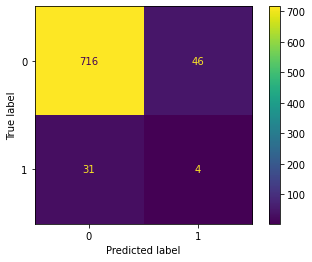

In [29]:
plot_confusion_matrix(dtc, X_val, y_val)

In [30]:
rfc = RandomForestClassifier(random_state=24)

In [31]:
rfc.fit(X_train_fin, y_train_fin)

RandomForestClassifier(random_state=24)

In [32]:
rfc.score(X_train_fin, y_train_fin)

1.0

In [33]:
rfc.score(X_val, y_val)

0.9560853199498118

/Users/zachpollatsek/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


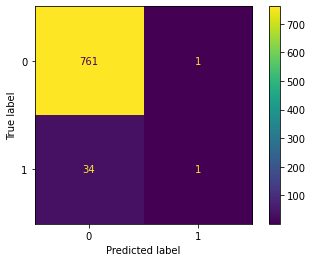

In [34]:
plot_confusion_matrix(rfc, X_val, y_val)

Create a pipeline for our random forest model. We will use a grid search object to optimize the hyperparameters of the model.

In [36]:
rfc_smote = ImPipeline(steps=[('CT', CT),
                              ('SM', subpipe_smote),
                              ('rfc', RandomForestClassifier(random_state=42))])

In [38]:
params = {'rfc__n_estimators': [10, 50, 100],
          'rfc__max_depth': [2, 4, 6, 8], 
          'rfc__min_samples_split': [2, 4, 6],
          'rfc__min_impurity_decrease': [0.1, 0.3, 0.5]}

In [47]:
rfc_smote_grid = GridSearchCV(rfc_smote, param_grid=params, scoring='f1', verbose=3)

In [48]:
rfc_smote_grid.fit(X_train_fin, y_train_fin)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5] END rfc__max_depth=2, rfc__min_impurity_decrease=0.1, rfc__min_samples_split=2, rfc__n_estimators=10;, score=0.098 total time=   0.1s
[CV 2/5] END rfc__max_depth=2, rfc__min_impurity_decrease=0.1, rfc__min_samples_split=2, rfc__n_estimators=10;, score=0.098 total time=   0.0s
[CV 3/5] END rfc__max_depth=2, rfc__min_impurity_decrease=0.1, rfc__min_samples_split=2, rfc__n_estimators=10;, score=0.099 total time=   0.0s
[CV 4/5] END rfc__max_depth=2, rfc__min_impurity_decrease=0.1, rfc__min_samples_split=2, rfc__n_estimators=10;, score=0.099 total time=   0.0s
[CV 5/5] END rfc__max_depth=2, rfc__min_impurity_decrease=0.1, rfc__min_samples_split=2, rfc__n_estimators=10;, score=0.099 total time=   0.0s
[CV 1/5] END rfc__max_depth=2, rfc__min_impurity_decrease=0.1, rfc__min_samples_split=2, rfc__n_estimators=50;, score=0.000 total time=   0.1s
[CV 2/5] END rfc__max_depth=2, rfc__min_impurity_decrease=0.1, rfc__min_samples

[CV 3/5] END rfc__max_depth=2, rfc__min_impurity_decrease=0.3, rfc__min_samples_split=2, rfc__n_estimators=100;, score=0.000 total time=   0.1s
[CV 4/5] END rfc__max_depth=2, rfc__min_impurity_decrease=0.3, rfc__min_samples_split=2, rfc__n_estimators=100;, score=0.000 total time=   0.1s
[CV 5/5] END rfc__max_depth=2, rfc__min_impurity_decrease=0.3, rfc__min_samples_split=2, rfc__n_estimators=100;, score=0.000 total time=   0.1s
[CV 1/5] END rfc__max_depth=2, rfc__min_impurity_decrease=0.3, rfc__min_samples_split=4, rfc__n_estimators=10;, score=0.098 total time=   0.0s
[CV 2/5] END rfc__max_depth=2, rfc__min_impurity_decrease=0.3, rfc__min_samples_split=4, rfc__n_estimators=10;, score=0.098 total time=   0.0s
[CV 3/5] END rfc__max_depth=2, rfc__min_impurity_decrease=0.3, rfc__min_samples_split=4, rfc__n_estimators=10;, score=0.099 total time=   0.0s
[CV 4/5] END rfc__max_depth=2, rfc__min_impurity_decrease=0.3, rfc__min_samples_split=4, rfc__n_estimators=10;, score=0.099 total time=   0

[CV 1/5] END rfc__max_depth=2, rfc__min_impurity_decrease=0.5, rfc__min_samples_split=4, rfc__n_estimators=100;, score=0.000 total time=   0.1s
[CV 2/5] END rfc__max_depth=2, rfc__min_impurity_decrease=0.5, rfc__min_samples_split=4, rfc__n_estimators=100;, score=0.000 total time=   0.1s
[CV 3/5] END rfc__max_depth=2, rfc__min_impurity_decrease=0.5, rfc__min_samples_split=4, rfc__n_estimators=100;, score=0.000 total time=   0.1s
[CV 4/5] END rfc__max_depth=2, rfc__min_impurity_decrease=0.5, rfc__min_samples_split=4, rfc__n_estimators=100;, score=0.000 total time=   0.1s
[CV 5/5] END rfc__max_depth=2, rfc__min_impurity_decrease=0.5, rfc__min_samples_split=4, rfc__n_estimators=100;, score=0.000 total time=   0.1s
[CV 1/5] END rfc__max_depth=2, rfc__min_impurity_decrease=0.5, rfc__min_samples_split=6, rfc__n_estimators=10;, score=0.098 total time=   0.0s
[CV 2/5] END rfc__max_depth=2, rfc__min_impurity_decrease=0.5, rfc__min_samples_split=6, rfc__n_estimators=10;, score=0.098 total time=  

[CV 4/5] END rfc__max_depth=4, rfc__min_impurity_decrease=0.1, rfc__min_samples_split=6, rfc__n_estimators=50;, score=0.000 total time=   0.1s
[CV 5/5] END rfc__max_depth=4, rfc__min_impurity_decrease=0.1, rfc__min_samples_split=6, rfc__n_estimators=50;, score=0.000 total time=   0.1s
[CV 1/5] END rfc__max_depth=4, rfc__min_impurity_decrease=0.1, rfc__min_samples_split=6, rfc__n_estimators=100;, score=0.000 total time=   0.1s
[CV 2/5] END rfc__max_depth=4, rfc__min_impurity_decrease=0.1, rfc__min_samples_split=6, rfc__n_estimators=100;, score=0.000 total time=   0.1s
[CV 3/5] END rfc__max_depth=4, rfc__min_impurity_decrease=0.1, rfc__min_samples_split=6, rfc__n_estimators=100;, score=0.000 total time=   0.1s
[CV 4/5] END rfc__max_depth=4, rfc__min_impurity_decrease=0.1, rfc__min_samples_split=6, rfc__n_estimators=100;, score=0.000 total time=   0.1s
[CV 5/5] END rfc__max_depth=4, rfc__min_impurity_decrease=0.1, rfc__min_samples_split=6, rfc__n_estimators=100;, score=0.000 total time=  

[CV 4/5] END rfc__max_depth=4, rfc__min_impurity_decrease=0.5, rfc__min_samples_split=2, rfc__n_estimators=50;, score=0.000 total time=   0.1s
[CV 5/5] END rfc__max_depth=4, rfc__min_impurity_decrease=0.5, rfc__min_samples_split=2, rfc__n_estimators=50;, score=0.000 total time=   0.1s
[CV 1/5] END rfc__max_depth=4, rfc__min_impurity_decrease=0.5, rfc__min_samples_split=2, rfc__n_estimators=100;, score=0.000 total time=   0.1s
[CV 2/5] END rfc__max_depth=4, rfc__min_impurity_decrease=0.5, rfc__min_samples_split=2, rfc__n_estimators=100;, score=0.000 total time=   0.1s
[CV 3/5] END rfc__max_depth=4, rfc__min_impurity_decrease=0.5, rfc__min_samples_split=2, rfc__n_estimators=100;, score=0.000 total time=   0.1s
[CV 4/5] END rfc__max_depth=4, rfc__min_impurity_decrease=0.5, rfc__min_samples_split=2, rfc__n_estimators=100;, score=0.000 total time=   0.1s
[CV 5/5] END rfc__max_depth=4, rfc__min_impurity_decrease=0.5, rfc__min_samples_split=2, rfc__n_estimators=100;, score=0.000 total time=  

[CV 4/5] END rfc__max_depth=6, rfc__min_impurity_decrease=0.1, rfc__min_samples_split=4, rfc__n_estimators=50;, score=0.000 total time=   0.1s
[CV 5/5] END rfc__max_depth=6, rfc__min_impurity_decrease=0.1, rfc__min_samples_split=4, rfc__n_estimators=50;, score=0.000 total time=   0.1s
[CV 1/5] END rfc__max_depth=6, rfc__min_impurity_decrease=0.1, rfc__min_samples_split=4, rfc__n_estimators=100;, score=0.000 total time=   0.1s
[CV 2/5] END rfc__max_depth=6, rfc__min_impurity_decrease=0.1, rfc__min_samples_split=4, rfc__n_estimators=100;, score=0.000 total time=   0.1s
[CV 3/5] END rfc__max_depth=6, rfc__min_impurity_decrease=0.1, rfc__min_samples_split=4, rfc__n_estimators=100;, score=0.000 total time=   0.1s
[CV 4/5] END rfc__max_depth=6, rfc__min_impurity_decrease=0.1, rfc__min_samples_split=4, rfc__n_estimators=100;, score=0.000 total time=   0.1s
[CV 5/5] END rfc__max_depth=6, rfc__min_impurity_decrease=0.1, rfc__min_samples_split=4, rfc__n_estimators=100;, score=0.000 total time=  

[CV 4/5] END rfc__max_depth=6, rfc__min_impurity_decrease=0.3, rfc__min_samples_split=6, rfc__n_estimators=50;, score=0.000 total time=   0.1s
[CV 5/5] END rfc__max_depth=6, rfc__min_impurity_decrease=0.3, rfc__min_samples_split=6, rfc__n_estimators=50;, score=0.000 total time=   0.1s
[CV 1/5] END rfc__max_depth=6, rfc__min_impurity_decrease=0.3, rfc__min_samples_split=6, rfc__n_estimators=100;, score=0.000 total time=   0.1s
[CV 2/5] END rfc__max_depth=6, rfc__min_impurity_decrease=0.3, rfc__min_samples_split=6, rfc__n_estimators=100;, score=0.000 total time=   0.1s
[CV 3/5] END rfc__max_depth=6, rfc__min_impurity_decrease=0.3, rfc__min_samples_split=6, rfc__n_estimators=100;, score=0.000 total time=   0.1s
[CV 4/5] END rfc__max_depth=6, rfc__min_impurity_decrease=0.3, rfc__min_samples_split=6, rfc__n_estimators=100;, score=0.000 total time=   0.1s
[CV 5/5] END rfc__max_depth=6, rfc__min_impurity_decrease=0.3, rfc__min_samples_split=6, rfc__n_estimators=100;, score=0.000 total time=  

[CV 4/5] END rfc__max_depth=8, rfc__min_impurity_decrease=0.1, rfc__min_samples_split=2, rfc__n_estimators=50;, score=0.000 total time=   0.1s
[CV 5/5] END rfc__max_depth=8, rfc__min_impurity_decrease=0.1, rfc__min_samples_split=2, rfc__n_estimators=50;, score=0.000 total time=   0.1s
[CV 1/5] END rfc__max_depth=8, rfc__min_impurity_decrease=0.1, rfc__min_samples_split=2, rfc__n_estimators=100;, score=0.000 total time=   0.1s
[CV 2/5] END rfc__max_depth=8, rfc__min_impurity_decrease=0.1, rfc__min_samples_split=2, rfc__n_estimators=100;, score=0.000 total time=   0.1s
[CV 3/5] END rfc__max_depth=8, rfc__min_impurity_decrease=0.1, rfc__min_samples_split=2, rfc__n_estimators=100;, score=0.000 total time=   0.1s
[CV 4/5] END rfc__max_depth=8, rfc__min_impurity_decrease=0.1, rfc__min_samples_split=2, rfc__n_estimators=100;, score=0.000 total time=   0.1s
[CV 5/5] END rfc__max_depth=8, rfc__min_impurity_decrease=0.1, rfc__min_samples_split=2, rfc__n_estimators=100;, score=0.000 total time=  

[CV 4/5] END rfc__max_depth=8, rfc__min_impurity_decrease=0.3, rfc__min_samples_split=4, rfc__n_estimators=50;, score=0.000 total time=   0.1s
[CV 5/5] END rfc__max_depth=8, rfc__min_impurity_decrease=0.3, rfc__min_samples_split=4, rfc__n_estimators=50;, score=0.000 total time=   0.1s
[CV 1/5] END rfc__max_depth=8, rfc__min_impurity_decrease=0.3, rfc__min_samples_split=4, rfc__n_estimators=100;, score=0.000 total time=   0.1s
[CV 2/5] END rfc__max_depth=8, rfc__min_impurity_decrease=0.3, rfc__min_samples_split=4, rfc__n_estimators=100;, score=0.000 total time=   0.1s
[CV 3/5] END rfc__max_depth=8, rfc__min_impurity_decrease=0.3, rfc__min_samples_split=4, rfc__n_estimators=100;, score=0.000 total time=   0.1s
[CV 4/5] END rfc__max_depth=8, rfc__min_impurity_decrease=0.3, rfc__min_samples_split=4, rfc__n_estimators=100;, score=0.000 total time=   0.1s
[CV 5/5] END rfc__max_depth=8, rfc__min_impurity_decrease=0.3, rfc__min_samples_split=4, rfc__n_estimators=100;, score=0.000 total time=  

[CV 4/5] END rfc__max_depth=8, rfc__min_impurity_decrease=0.5, rfc__min_samples_split=6, rfc__n_estimators=50;, score=0.000 total time=   0.1s
[CV 5/5] END rfc__max_depth=8, rfc__min_impurity_decrease=0.5, rfc__min_samples_split=6, rfc__n_estimators=50;, score=0.000 total time=   0.1s
[CV 1/5] END rfc__max_depth=8, rfc__min_impurity_decrease=0.5, rfc__min_samples_split=6, rfc__n_estimators=100;, score=0.000 total time=   0.1s
[CV 2/5] END rfc__max_depth=8, rfc__min_impurity_decrease=0.5, rfc__min_samples_split=6, rfc__n_estimators=100;, score=0.000 total time=   0.1s
[CV 3/5] END rfc__max_depth=8, rfc__min_impurity_decrease=0.5, rfc__min_samples_split=6, rfc__n_estimators=100;, score=0.000 total time=   0.1s
[CV 4/5] END rfc__max_depth=8, rfc__min_impurity_decrease=0.5, rfc__min_samples_split=6, rfc__n_estimators=100;, score=0.000 total time=   0.1s
[CV 5/5] END rfc__max_depth=8, rfc__min_impurity_decrease=0.5, rfc__min_samples_split=6, rfc__n_estimators=100;, score=0.000 total time=  

GridSearchCV(estimator=Pipeline(steps=[('CT',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         [1, 7,
                                                                          8]),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         [0, 2,
                                                                          3, 4,
                                                                          5, 6,
                                                                          9])])),
                                       ('SM',
                                        SMOTE(random_state=42,
                                              sampling_strategy='minority')),
                                       ('rfc',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'rfc__max_depth': [2, 4, 6, 8],
                         'rfc__min_impurity_decrease': [0.1, 0.3, 0.5],
                         'rfc__min_samples_split': [2, 4, 6],
                         'rfc__n_estimators': [10, 50, 100]},
             scoring='f1', verbose=3)

In [49]:
pd.DataFrame(rfc_smote_grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rfc__max_depth,param_rfc__min_impurity_decrease,param_rfc__min_samples_split,param_rfc__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.038711,0.014828,0.002955,0.000194,2,0.1,2,10,"{'rfc__max_depth': 2, 'rfc__min_impurity_decre...",0.098361,0.098361,0.098507,0.098507,0.098507,0.098449,0.000072,1
1,0.071260,0.002297,0.005061,0.000079,2,0.1,2,50,"{'rfc__max_depth': 2, 'rfc__min_impurity_decre...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37
2,0.125159,0.002396,0.007704,0.000119,2,0.1,2,100,"{'rfc__max_depth': 2, 'rfc__min_impurity_decre...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37
3,0.025496,0.000987,0.002838,0.000026,2,0.1,4,10,"{'rfc__max_depth': 2, 'rfc__min_impurity_decre...",0.098361,0.098361,0.098507,0.098507,0.098507,0.098449,0.000072,1
4,0.070307,0.001335,0.005161,0.000106,2,0.1,4,50,"{'rfc__max_depth': 2, 'rfc__min_impurity_decre...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,0.069187,0.001056,0.005075,0.000107,8,0.5,4,50,"{'rfc__max_depth': 8, 'rfc__min_impurity_decre...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37
104,0.124670,0.001199,0.007988,0.000222,8,0.5,4,100,"{'rfc__max_depth': 8, 'rfc__min_impurity_decre...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37
105,0.024784,0.000156,0.002812,0.000047,8,0.5,6,10,"{'rfc__max_depth': 8, 'rfc__min_impurity_decre...",0.098361,0.098361,0.098507,0.098507,0.098507,0.098449,0.000072,1
106,0.069194,0.000979,0.005085,0.000052,8,0.5,6,50,"{'rfc__max_depth': 8, 'rfc__min_impurity_decre...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37


In [50]:
rfc_smote_grid.best_params_

{'rfc__max_depth': 2,
 'rfc__min_impurity_decrease': 0.1,
 'rfc__min_samples_split': 2,
 'rfc__n_estimators': 10}

In [51]:
best_rfc_smote = ImPipeline(steps=[('CT', CT),
                                   ('SM', subpipe_smote),
                                   ('rfc', RandomForestClassifier(random_state=42,
                                                                  max_depth=2, 
                                                                  min_impurity_decrease=0.1,
                                                                  min_samples_split=2,
                                                                  n_estimators=10))])

In [52]:
best_rfc_smote.fit(X_train_fin, y_train_fin)

Pipeline(steps=[('CT',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  [1, 7, 8]),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  [0, 2, 3, 4, 5, 6, 9])])),
                ('SM', SMOTE(random_state=42, sampling_strategy='minority')),
                ('rfc',
                 RandomForestClassifier(max_depth=2, min_impurity_decrease=0.1,
                                        n_estimators=10, random_state=42))])

In [53]:
best_rfc_smote.score(X_train_fin, y_train_fin)

0.948227172889865

In [54]:
best_rfc_smote.score(X_val, y_val)

0.9560853199498118

In [55]:
rfc_val_f1 = f1_score(y_val, best_rfc_smote.predict(X_val))
rfc_val_f1

0.0

/Users/zachpollatsek/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


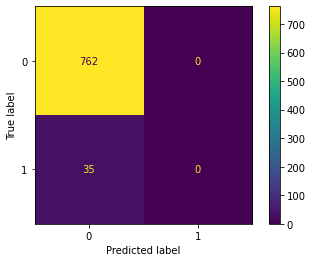

In [59]:
plot_confusion_matrix(best_rfc_smote, X_val, y_val)

## XGBoost Models

In [ ]:
xgb_smote_pipe = ImPipeline(steps=[('CT', CT),
                                   ('SM', subpipe_smote),
                                   ('xgb', (random_state=42,)])